In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class StupidModel:
    def __init__(self):
        self.dimension = 0
        self.weights = []
        self.bias = 0
        self.learning_rate = 0.01
        self.epochs = 1000

    def train(self, X, y):
        self.dimension = X.shape[1] # Для визуализации 
        self.weights = np.zeros(self.dimension) # сколько измеренийц столько и весов, удивительно
        self.bias = 0 # его можно любым брать
        for _ in range(self.epochs): # тренировочка
            for i in range(len(X)): # пробег по каждой строке даты
                y_pred = np.dot(X[i], self.weights) + self.bias # предсказание (тупое математическое перемножение)
                error = y[i] - y_pred # еррор
                self.weights += self.learning_rate * error * X[i] # больше еррор => больше смещение веса
                self.bias += self.learning_rate * error 

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def print_evaluation_metrics(self, y_true, y_pred):
        mse = np.mean((y_pred - y_true) ** 2)
        # MSE = 1 / n * sum((y-Y)^2)
        # Нужен чтобы оценить средний квадрат ошибки. Это позволяет грубо оценить "хорошесть" модели 

        rmse = np.sqrt(mse)
        # RMSE = sqrt(MSE)
        # Нужен чтобы оценка средней ошибки изменялась не в квадратах единиц, а в еденицах
        # по сути просто чуть более приближено к реальности        

        mae = np.mean(np.abs(y_pred - y_true))
        # MAE = 1 / n * sum(y-Y)
        # Нужно чтобы было как MSE, но меньше колебалось из-за выбросов, которые сильно могут 
        # подпортить малину MSE'шке 
        
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r_squared = 1 - (ss_residual / ss_total)
        
        # Adjusted R-squared
        n = len(y_true)  # Number of observations
        p = self.dimension  # Number of predictors
        adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
        
        # Print the metrics
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"R-squared: {r_squared:.4f}")
        print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")

    def analyze_result(self, X, y):
        y_pred = self.predict(X)
        mse = np.mean((y_pred - y) ** 2)
        print(f"Mean Squared Error: {mse}")
        print(f"Weights: {self.weights}")
        print(f"Bias: {self.bias}")
        if self.dimension == 1:
            plt.scatter(X[:, 0], y, color='blue', label='Actual')
            plt.scatter(X[:, 0], y_pred, color='red', label='Predicted')
            plt.xlabel('X')
            plt.ylabel('y')
            plt.legend()
            plt.show()
        elif self.dimension == 2:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(X[:, 0], X[:, 1], y, color='blue', label='Actual')
            ax.scatter(X[:, 0], X[:, 1], y_pred, color='red', label='Predicted')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')
            ax.set_zlabel('y')
            ax.legend()
            plt.show()

Mean Squared Error: 0.3284890279845161
Weights: [3.08026938]
Bias: 1.9269469354482327


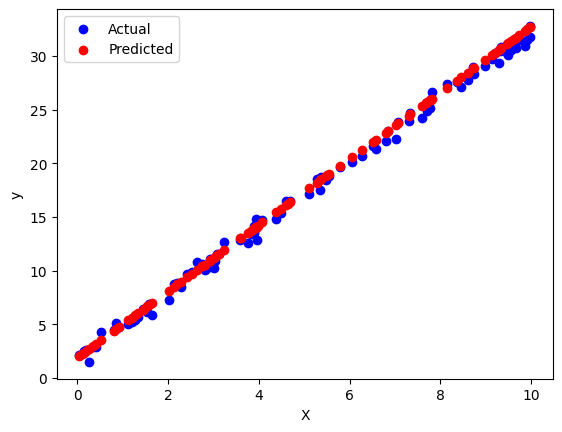

In [3]:
num_samples = 100
X = np.random.rand(num_samples, 1) * 10
y = 3 * X[:, 0] + 2 + np.random.randn(num_samples) * 0.5 

model = StupidModel()
model.train(X, y)
model.analyze_result(X, y)

Mean Squared Error: 0.23095960813766617
Weights: [1.01278204 1.99039836]
Bias: 2.9310780557769647


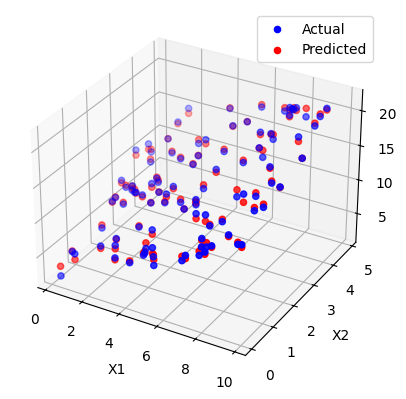

In [4]:
num_samples = 100
X1 = np.random.rand(num_samples) * 10
X2 = np.random.rand(num_samples) * 5
X = np.column_stack((X1, X2))
y = 1 * X1 + 2 * X2 + 3 + np.random.randn(num_samples) * 0.5

model = StupidModel()
model.train(X, y)

model.analyze_result(X, y)

In [5]:
num_samples = 100
X1 = np.random.randn(num_samples)
X2 = np.random.randn(num_samples)
X3 = np.random.randn(num_samples)
X = np.column_stack((X1, X2, X3))
y = 2*X1 - X2 + 0.5*X3 + 1 + np.random.randn(num_samples)*0.1

model = StupidModel()
model.train(X, y)

model.analyze_result(X, y)

Mean Squared Error: 0.009743773932371353
Weights: [ 1.99689542 -0.99757825  0.50410495]
Bias: 1.0030260007335359


In [6]:
class NotSoStupidModel(StupidModel):
    def __init__(self, n_splits=5):
        super().__init__()
        self.n_splits = n_splits
    
    def train(self, X, y):
        X = np.array(X)
        y = np.array(y)
        num_samples = X.shape[0]

        indices = np.arange(num_samples) # индексируем данные чтобы нам проще было делать сеты
        np.random.shuffle(indices) # мешаем данные чтобы нейронке было хуже

        fold_size = num_samples // self.n_splits
        folds = []
        start = 0
        for i in range(self.n_splits):
            end = start + fold_size if i < self.n_splits - 1 else num_samples
            fold_indices = indices[start:end]
            folds.append(fold_indices)
            start = end # в итоге у нас лист листов индексов, каждый индекс в конце концов ссылет на
            # строку с данными

        best_val_error = float('inf')
        best_weights = None
        best_bias = None
        validation_errors = []

        for i in range(self.n_splits):
            val_indices = folds[i] # валидационный сет

            # а остальные для трейна
            train_indices = np.concatenate([folds[j] for j in range(self.n_splits) if j != i])

            X_train, y_train = X[train_indices], y[train_indices]
            X_val, y_val = X[val_indices], y[val_indices]

            # каждой итерации свои параметры, в конце просто лучшие выберем
            self.dimension = X_train.shape[1]
            self.weights = np.zeros(self.dimension)
            self.bias = 0

            # то же саморе что и в тупой модели
            for _ in range(self.epochs):
                for idx in range(len(X_train)):
                    y_pred = np.dot(X_train[idx], self.weights) + self.bias
                    error = y_train[idx] - y_pred
                    self.weights += self.learning_rate * error * X_train[idx]
                    self.bias += self.learning_rate * error

            # а вот валидация именно по сету валидации
            y_val_pred = self.predict(X_val)
            val_mse = np.mean((y_val_pred - y_val)**2)
            validation_errors.append(val_mse)

            # ну и если да, то сохраняем результат
            if val_mse < best_val_error:
                best_val_error = val_mse
                best_weights = self.weights.copy()
                best_bias = self.bias

        self.weights = best_weights
        self.bias = best_bias


Mean Squared Error: 0.30448384173490967
Weights: [0.96862213 1.97766812]
Bias: 3.0511459080747803


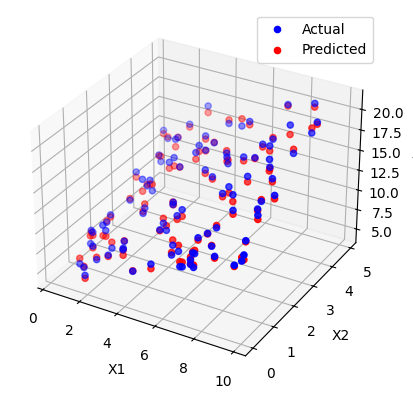

Mean Squared Error: 0.5744039677487172
Weights: [0.8897696  2.01451955]
Bias: 3.0070181156978


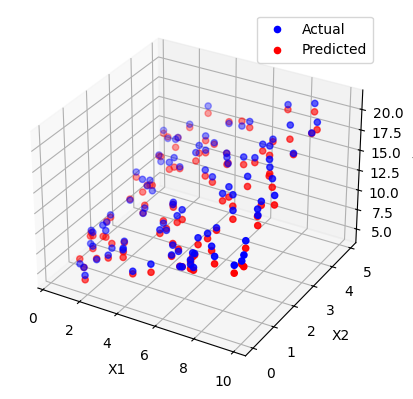

In [7]:
num_samples = 100
X1 = np.random.rand(num_samples) * 10
X2 = np.random.rand(num_samples) * 5
X = np.column_stack((X1, X2))
y = 1 * X1 + 2 * X2 + 3 + np.random.randn(num_samples) * 0.5

model = NotSoStupidModel()
model.train(X, y)

model.analyze_result(X, y)


model = StupidModel()
model.train(X, y)

model.analyze_result(X, y)